In [1]:
from IPython.utils import io

# with io.capture_output() as captured:
#   !pip3 install scikit-learn;

import numpy as np

from util import train_test_df, evaluate as evaluator, interaction_matrix, heatmaps
from mfactorization import mf, mf_default_config


def pca(M):
  '''
  reduces dimension of nxm matrix M to nx64
  '''

  from sklearn.decomposition import PCA

  R = PCA(64).fit_transform(M)

  return R

factorizing interaction matrix:


0it [00:00, ?it/s]

err: 4.68e+04, lr: 0.0027999 

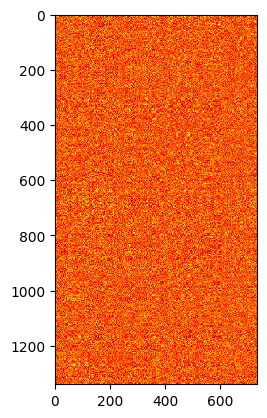

32it [00:01, 42.46it/s]

err: 8.70e+64, lr: 0.0071114 , last batch: 16


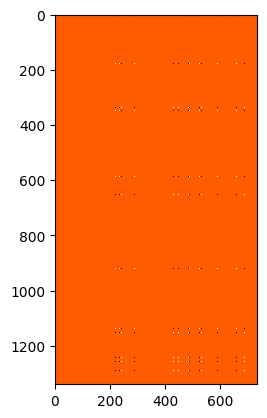

67it [00:02, 44.66it/s]

err: 1.44e+52, lr: 0.0051355 , last batch: 4


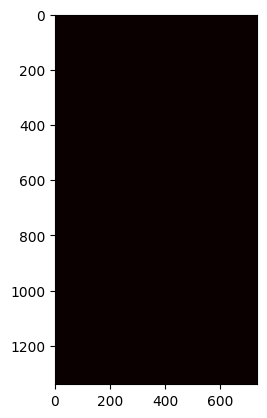

105it [00:02, 40.19it/s]/Users/amadeus/Documents/information-retrieval-course/hw3/mfactorization/mf.py:157: RuntimeWarning: overflow encountered in multiply
  qq = q[i] + lr * (e * p[j] - reg*q[i])
/Users/amadeus/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:49: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/Users/amadeus/Documents/information-retrieval-course/hw3/mfactorization/mf.py:82: RuntimeWarning: overflow encountered in multiply
  e = (r[n] - (q@p.T)[n]).sum() + reg*(q*q)[n[0]].sum() + reg*(p*p)[n[1]].sum()
/Users/amadeus/Library/Python/3.9/lib/python/site-packages/matplotlib/image.py:463: RuntimeWarning: overflow encountered in scalar multiply
  newmin = vmid - dv * fact
/Users/amadeus/Library/Python/3.9/lib/python/site-packages/matplotlib/image.py:468: RuntimeWarning: overflow encountered in scalar multiply
  newmax = vmid + dv * fact


err: nan, lr: 0.0005 , last batch: 1


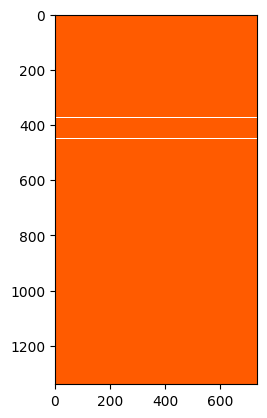

/Users/amadeus/Documents/information-retrieval-course/hw3/mfactorization/mf.py:157: RuntimeWarning: invalid value encountered in add
  qq = q[i] + lr * (e * p[j] - reg*q[i])
110it [00:03, 27.65it/s]/Users/amadeus/Documents/information-retrieval-course/hw3/mfactorization/mf.py:158: RuntimeWarning: invalid value encountered in add
  pp = p[j] + lr * (e * q[i] - reg*p[j])
115it [00:03, 29.72it/s]/Users/amadeus/Documents/information-retrieval-course/hw3/mfactorization/mf.py:158: RuntimeWarning: overflow encountered in multiply
  pp = p[j] + lr * (e * q[i] - reg*p[j])
139it [00:04, 39.64it/s]

err: nan, lr: 0.0005 , last batch: 1


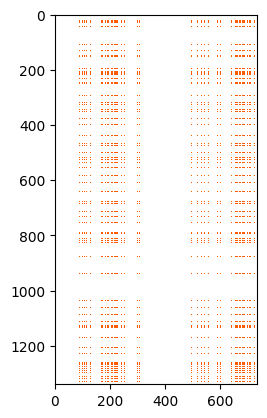

178it [00:05, 38.76it/s]

err: nan, lr: 0.0005 , last batch: 1


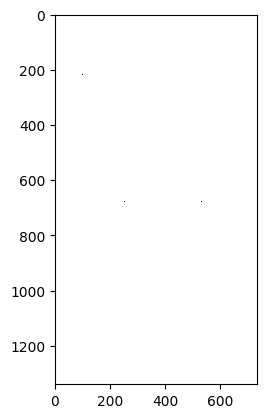

212it [00:06, 38.53it/s]

err: nan, lr: 0.0005 , last batch: 1


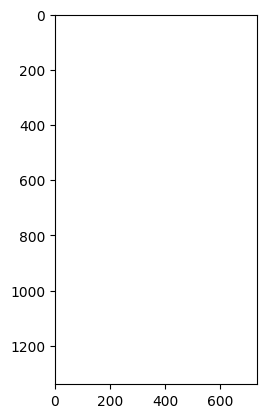

251it [00:07, 41.64it/s]

err: nan, lr: 0.0005 , last batch: 1


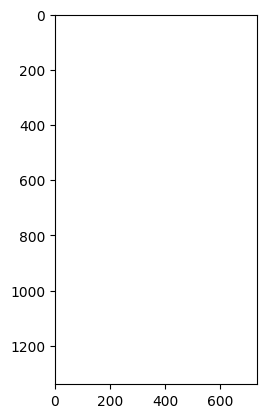

288it [00:08, 40.14it/s]

err: nan, lr: 0.0005 , last batch: 1


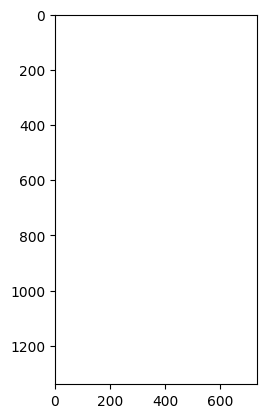

300it [00:08, 34.25it/s]


best error: 4.68e+04


NameError: name 'Rm' is not defined

In [2]:
# 1.
df_train, df_test = train_test_df()
R = interaction_matrix(df_train)

# 2.
print("factorizing interaction matrix:")
# lr=(5e-3, 1e-4)
Q, P = mf(R, print_step=8, single_lr=0.0005, n_epochs=300, single_epochs=200, sample_s=0.01, batch_sample_s=0.01, reg=0.001, ff=0.01)


# 3.
E = np.load('bert_item_encodings.npy')

# 3.a
Pa = pca(E)
Ra = Q @ Pa.T

# 3.b
Pb = pca(np.hstack((E, P)))
Rb = Q @ Pb.T

# 4.
evaluate = lambda r: evaluator(r, df_test) # syntax suger

# 4. MF
Em = evaluate(Rm)

# 4. BERT a
Ea = evaluate(Ra)
# 4. BERT b
Eb = evaluate(Rb)

# 4. Extra evaluations
E0 = evaluate(R)

Rt = interaction_matrix(df_test)
Et = evaluate(Rt)

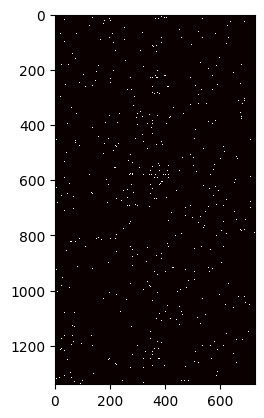

In [ ]:
heatmaps([Rt])

Mistake in the problem: the corresponding matrix for items is P (not Q)

In [ ]:
import pandas as pd

columns = E0.keys()
df = pd.DataFrame(data=(E0, Et, Em, Ea, Eb), columns=columns)

df.insert(0, 'method', [
    'R (train data)',
    'R (test data)',
    'matrix factorization',
    'BERT replace Q',
    'BERT concat with Q'
])

df

,method,accuracy,recall,ndcg,rank correlation
0,R (train data),1.59,1.58,0.02,0.90
1,R (test data),100,99,1.00,0.99
2,matrix factorization,0.62,0.61,0.01,0.47
3,BERT replace Q,0.49,0.48,0.00,0.01
4,BERT concat with Q,0.45,0.45,0.00,0.01


set i , j


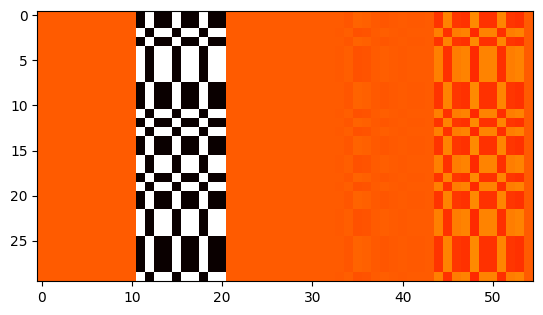

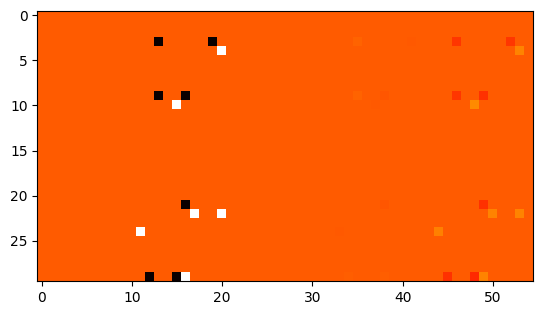

In [ ]:
def find_window(w, h):
    n, m = Rt.shape
    a = np.zeros((n-h, m-w))
    for i in range(a.shape[0]):
        for j in range(a.shape[1]):
            a[i,j] = Rt[i:i+h, j:j+w].sum()
    
    return np.unravel_index(a.argmax(), a.shape)

try:
    a = i, j
except:
    i, j = -1, -1

def win(M, width=10, height=30):
    global i, j
    if i < 0 and j < 0:
        i, j = find_window(width, height)
        print("set i , j")

    return M[i:i+height, j:j+width]


RRmRtRaRb = (R, Rm, Rt, Ra, Rb)
RRmRtRaRb = [win(M) for M in RRmRtRaRb]

heatmaps(RRmRtRaRb)
heatmaps([M*win(Rt) for M in RRmRtRaRb])

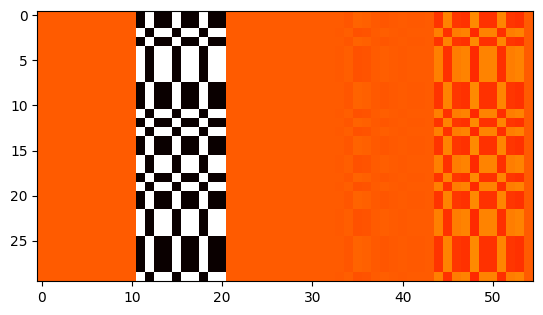

In [ ]:
def mark(M, windowed=True):
    return M
    T = win(Rt) if windowed else Rt
    return M + ((M - 0.5)*(T - 0.5)) * 1.2

heatmaps([mark(win(M)) for M in (R, Rm, Rt, Ra, Rb)])

In [ ]:
Rm.mean()

0.2267516442344892

In [ ]:
print("We expect R_train to have almost zero score (since it has zero value for almost every item)")
print(E0)
print()

print("We expect R_test to have almost 1 score (since it has memorized test dataset)")
print(Et)
print()

print("R estimation (with matrix factorization)")
print(Em)
print()

print("Replace Q with BERT's encoding")
print(Ea)
print()

print("Concat BERT encoding")
print(Eb)
print()

We expect R_train to have almost zero score (since it has zero value for almost every item)
{'accuracy': '1.59', 'recall': '1.58', 'ndcg': '0.02', 'rank correlation': '0.90'}

We expect R_test to have almost 1 score (since it has memorized test dataset)
{'accuracy': '100', 'recall': '99', 'ndcg': '1.00', 'rank correlation': '0.99'}

R estimation (with matrix factorization)
{'accuracy': '0.62', 'recall': '0.61', 'ndcg': '0.01', 'rank correlation': '0.47'}

Replace Q with BERT's encoding
{'accuracy': '0.49', 'recall': '0.48', 'ndcg': '0.00', 'rank correlation': '0.01'}

Concat BERT encoding
{'accuracy': '0.45', 'recall': '0.45', 'ndcg': '0.00', 'rank correlation': '0.01'}



0it [00:00, ?it/s]

err: 2.88e+04, lr: 0.001 

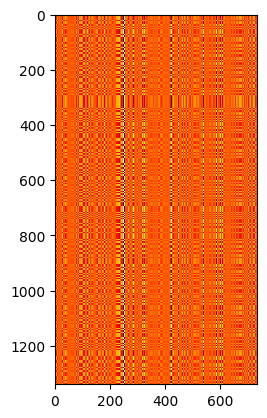

15it [00:01, 15.67it/s]

err: 2.82e+04, lr: 0.001 

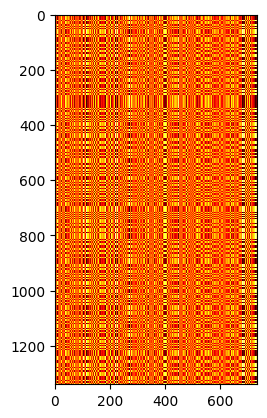

31it [00:02, 15.65it/s]

err: 2.81e+04, lr: 0.001 

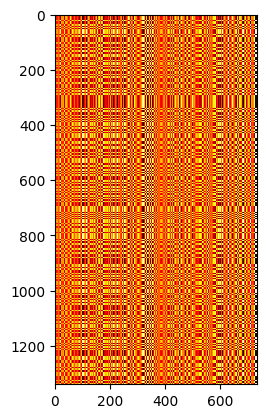

47it [00:03, 15.63it/s]

err: 2.81e+04, lr: 0.001 

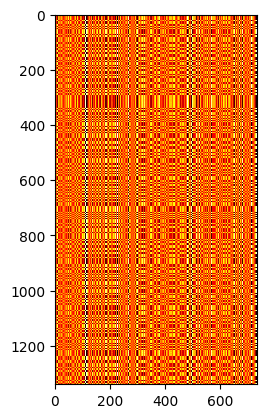

50it [00:03, 12.76it/s]


best error: 2.80e+04


{'accuracy': '0.50',
 'recall': '0.50',
 'ndcg': '0.00',
 'rank correlation': '0.03'}

In [ ]:
Qa, Pa2 = mf(R, qp=(Q, Pa), single_lr=0.001, n_epochs=0, single_epochs=50, sample_s=0.08, print_step=3) 
Ra2 = Qa @ Pa2.T
evaluate(Ra2)